This notebook ensembles predictions from various models (by average). First, there are some libraries and datasets that we need to load.

In [1]:
!pip install transformers

     |████████████████████████████████| 1.4MB 7.7MB/s 
     |████████████████████████████████| 890kB 33.0MB/s 
     |████████████████████████████████| 2.9MB 47.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=324e91a74390516e88b1ba11b1e6f12d2c5ab6fb768aed4f448958f80ef288cb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error, accuracy_score
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AdamW, get_linear_schedule_with_warmup, pipeline
import torch
import pandas as pd
import argparse
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import chain, combinations

# sentiment = pipeline("sentiment-analysis")

We use Google Drive for storing/retrieving data files, so they must be in the appropriate file structure within Drive for this code to work.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we read in the Hahackathon data and display some baselines and statistics.

num examples: 8000
num humor: 4932 num not humor: 3068
humor label majority class f1: 0.7627590473244664 humor label majority class accuracy: 0.6165
num examples with humor controversy: 4932
num controversial: 2465 num not controversial: 2467
humor controversy majority class f1: 0.0 humor controversy majority class accuracy: 0.5002027575020276
num examples with humor ratings: 4932
humor ratings -- min: 0.1 median: 2.28 mean: 2.2605251419302514 max: 4.0
humor ratings mean rmse: 0.5669164577335435 humor ratings median rmse: 0.567250861741069


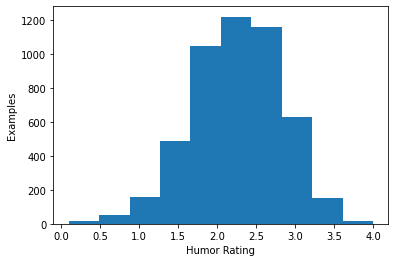

humor ratings (controversial) -- min: 0.45 median: 2.37 mean: 2.3590101419878295 max: 3.68


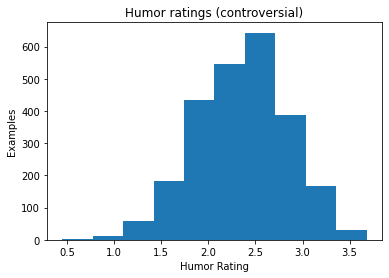

humor ratings (not controversial) -- min: 0.1 median: 2.15 mean: 2.1621199837859746 max: 4.0


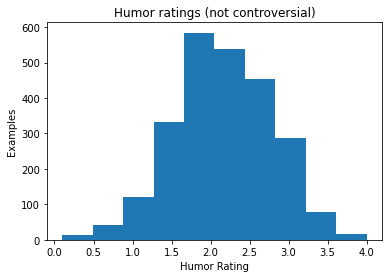

off ratings -- min: 0.0 median: 0.1 mean: 0.5853250000000001 max: 4.85
off ratings mean rmse: 0.9798939454731823 off ratings median rmse: 1.0934955418290466


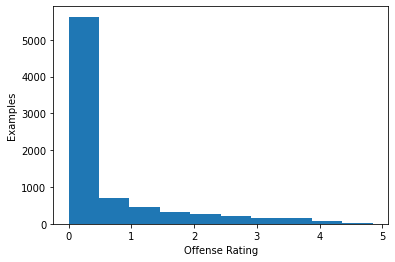

off ratings (humorous) -- min: 0.0 median: 0.35 mean: 0.8987226277372263 max: 4.85


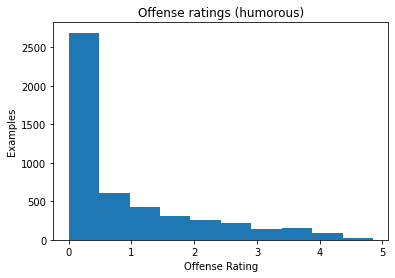

off ratings (not humorous) -- min: 0.0 median: 0.0 mean: 0.08151890482398957 max: 3.65


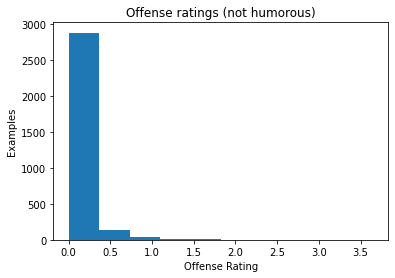

In [6]:
hahackathon_file = "/content/drive/My Drive/Hahackathon/train.csv"
hahackathon_df = pd.read_csv(hahackathon_file, encoding="utf-8")

hahackathon_texts = list(hahackathon_df["text"])
hahackathon_off_ratings = list(hahackathon_df["offense_rating"])
hahackathon_humor_labels = list(hahackathon_df["is_humor"])
hahackathon_humor_ratings = list(hahackathon_df["humor_rating"].fillna(value=-1))
hahackathon_controversy_labels = list(hahackathon_df["humor_controversy"].fillna(value=-1))

num_total = len(hahackathon_humor_labels)
print("num examples:", num_total)
num_humorous = np.sum(np.array(hahackathon_humor_labels) == 1)
print("num humor:", num_humorous, "num not humor:", num_total - num_humorous)
majority_class_humor = np.max([num_humorous, num_total - num_humorous]) / num_total
majority_class_humor_f1 = f1_score(np.array(hahackathon_humor_labels), np.ones(num_total))#, labels=[0,1], average='macro')
print("humor label majority class f1:", majority_class_humor_f1, "humor label majority class accuracy:", majority_class_humor)

humor_controversy_minus_nan = np.array(hahackathon_controversy_labels)
humor_controversy_minus_nan = humor_controversy_minus_nan[humor_controversy_minus_nan != -1]
print("num examples with humor controversy:", len(humor_controversy_minus_nan))
num_controversial = np.sum(humor_controversy_minus_nan == 1)
print("num controversial:", num_controversial, "num not controversial:", len(humor_controversy_minus_nan) - num_controversial)
majority_class_controversial = np.max([num_controversial, len(humor_controversy_minus_nan) - num_controversial]) / len(humor_controversy_minus_nan)
majority_class_controversial_f1 = f1_score(np.array(humor_controversy_minus_nan), np.zeros(len(humor_controversy_minus_nan)))#, labels=[0,1], average='macro')
print("humor controversy majority class f1:", majority_class_controversial_f1, "humor controversy majority class accuracy:", majority_class_controversial)

humor_ratings_minus_nan = np.array(hahackathon_humor_ratings)
humor_ratings_minus_nan = humor_ratings_minus_nan[humor_ratings_minus_nan != -1]
print("num examples with humor ratings:", len(humor_ratings_minus_nan))
print("humor ratings -- min:", np.min(humor_ratings_minus_nan), "median:", np.median(humor_ratings_minus_nan), "mean:", np.mean(humor_ratings_minus_nan), "max:", np.max(humor_ratings_minus_nan))
humor_ratings_mean_rmse = mean_squared_error(humor_ratings_minus_nan, np.ones_like(humor_ratings_minus_nan) * np.mean(humor_ratings_minus_nan), squared=False)
humor_ratings_median_rmse = mean_squared_error(humor_ratings_minus_nan, np.ones_like(humor_ratings_minus_nan) * np.median(humor_ratings_minus_nan), squared=False)
print("humor ratings mean rmse:", humor_ratings_mean_rmse, "humor ratings median rmse:", humor_ratings_median_rmse)

plt.hist(humor_ratings_minus_nan, bins = 10)
plt.xlabel("Humor Rating")
plt.ylabel("Examples")
plt.show()

humor_controversial = humor_ratings_minus_nan[humor_controversy_minus_nan == 1]
print("humor ratings (controversial) -- min:", np.min(humor_controversial), "median:", np.median(humor_controversial), "mean:", np.mean(humor_controversial), "max:", np.max(humor_controversial))

plt.hist(humor_controversial, bins = 10)
plt.title("Humor ratings (controversial)")
plt.xlabel("Humor Rating")
plt.ylabel("Examples")
plt.show()

humor_not_controversial = humor_ratings_minus_nan[humor_controversy_minus_nan == 0]
print("humor ratings (not controversial) -- min:", np.min(humor_not_controversial), "median:", np.median(humor_not_controversial), "mean:", np.mean(humor_not_controversial), "max:", np.max(humor_not_controversial))

plt.hist(humor_not_controversial, bins = 10)
plt.title("Humor ratings (not controversial)")
plt.xlabel("Humor Rating")
plt.ylabel("Examples")
plt.show()

print("off ratings -- min:", np.min(hahackathon_off_ratings), "median:", np.median(hahackathon_off_ratings), "mean:", np.mean(hahackathon_off_ratings), "max:", np.max(hahackathon_off_ratings))
off_ratings_mean_rmse = mean_squared_error(hahackathon_off_ratings, np.ones_like(hahackathon_off_ratings) * np.mean(hahackathon_off_ratings), squared=False)
off_ratings_median_rmse = mean_squared_error(hahackathon_off_ratings, np.ones_like(hahackathon_off_ratings) * np.median(hahackathon_off_ratings), squared=False)
print("off ratings mean rmse:", off_ratings_mean_rmse, "off ratings median rmse:", off_ratings_median_rmse)

plt.hist(hahackathon_off_ratings, bins = 10)
plt.xlabel("Offense Rating")
plt.ylabel("Examples")
plt.show()

off_humorous = np.array(hahackathon_off_ratings)[np.array(hahackathon_humor_labels) == 1]
print("off ratings (humorous) -- min:", np.min(off_humorous), "median:", np.median(off_humorous), "mean:", np.mean(off_humorous), "max:", np.max(off_humorous))

plt.hist(off_humorous, bins = 10)
plt.title("Offense ratings (humorous)")
plt.xlabel("Offense Rating")
plt.ylabel("Examples")
plt.show()

off_not_humorous = np.array(hahackathon_off_ratings)[np.array(hahackathon_humor_labels) == 0]
print("off ratings (not humorous) -- min:", np.min(off_not_humorous), "median:", np.median(off_not_humorous), "mean:", np.mean(off_not_humorous), "max:", np.max(off_not_humorous))

plt.hist(off_not_humorous, bins = 10)
plt.title("Offense ratings (not humorous)")
plt.xlabel("Offense Rating")
plt.ylabel("Examples")
plt.show()

In [7]:
hahackathon_train_file = "/content/drive/My Drive/Hahackathon/internal_split/train_90.csv"
hahackathon_train_df = pd.read_csv(hahackathon_train_file, encoding="utf-8")

haha_train_texts = list(hahackathon_train_df["text"])
haha_train_off_ratings = list(hahackathon_train_df["offense_rating"])
haha_train_humor_labels = list(hahackathon_train_df["is_humor"])
haha_train_humor_ratings = list(hahackathon_train_df["humor_rating"].fillna(value=-1))
haha_train_humor_controversy = list(hahackathon_train_df["humor_controversy"].fillna(value=-1))

hahackathon_val_file = "/content/drive/My Drive/Hahackathon/internal_split/test_10.csv"
hahackathon_val_df = pd.read_csv(hahackathon_val_file, encoding="utf-8")

haha_val_texts = list(hahackathon_val_df["text"])
haha_val_off_ratings = np.array(hahackathon_val_df["offense_rating"])
haha_val_humor_labels = np.array(hahackathon_val_df["is_humor"])
haha_val_humor_ratings = np.array(hahackathon_val_df["humor_rating"].fillna(value=-1))
haha_val_humor_controversy = np.array(hahackathon_val_df["humor_controversy"].fillna(value=-1))

This function is used to enumerate all possible model combinations for finding the best way to ensemble for each task (optimized on internal dev set).

In [8]:
def get_combinations(x):
    s = list(x)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]

len(list(get_combinations(list(range(7)))))

127

This function generates predictions for the leaderboard using our simple statistical baselines.

In [9]:
def generate_simple_predictions(all_models, out_path):
    
    ids = None

    for model in all_models:
        base_path = "/content/drive/My Drive/Hahackathon/"
        
        preds_df = pd.read_csv(base_path + model + "_out_dev_preds.csv")

        if ids is None:
            ids = list(preds_df["id"])
        else:
            assert ids == list(preds_df["id"])

    with open(out_path, "w") as out_file:
        out_file.write("id,is_humor,humor_rating,humor_controversy,offense_rating\n")

        for i in range(len(ids)):
            format_str = ",".join([str(ids[i]), str(1), str(2.2605251419), str(0), str(0.585325)])
            # print(format_str)
            out_file.write(format_str + "\n")

            if i % 100 == 0:
                print(i, "done")

This function uses our model ensembles to generate predictions for the leaderboard (possibly using some subset of models for each task).

In [35]:
def generate_predictions(all_models, humor_comb, humor_rating_comb, controversy_comb, off_comb, out_path):
    
    ids = None

    all_humor_logits = []
    all_humor_rating_logits = []
    all_controversy_logits = []
    all_off_logits = []


    for model in all_models:
        base_path = "/content/drive/My Drive/Hahackathon/"
        
        preds_df = pd.read_csv(base_path + model + "_out_dev_preds.csv")

        if ids is None:
            ids = list(preds_df["id"])
        else:
            assert ids == list(preds_df["id"])

        model_humor_logits = list(preds_df["is_humor"])
        model_humor_rating_logits = list(preds_df["humor_rating"])
        model_controversy_logits = list(preds_df["humor_controversy"])
        model_off_logits = list(preds_df["offense_rating"])

        if model in humor_comb:
            all_humor_logits.append(model_humor_logits)
        if model in humor_rating_comb:
            all_humor_rating_logits.append(model_humor_rating_logits)
        if model in controversy_comb:
            all_controversy_logits.append(model_controversy_logits)
        if model in off_comb:
            all_off_logits.append(model_off_logits)


    mean_humor_logits = np.mean(all_humor_logits, axis=0)
    mean_humor_rating_logits = np.mean(all_humor_rating_logits, axis=0)
    mean_controversy_logits = np.mean(all_controversy_logits, axis=0)
    mean_off_logits = np.mean(all_off_logits, axis=0)

    mean_humor_logits = np.round(mean_humor_logits)
    mean_controversy_logits = np.round(mean_controversy_logits)

    with open(out_path, "w") as out_file:
        out_file.write("id,is_humor,humor_rating,humor_controversy,offense_rating\n")

        for i in range(len(ids)):
            format_str = ",".join([str(ids[i]), str(int(mean_humor_logits[i])), str(mean_humor_rating_logits[i]), str(int(mean_controversy_logits[i])), str(mean_off_logits[i])])
            # print(format_str)
            out_file.write(format_str + "\n")

            if i % 100 == 0:
                print(i, "done")

Ensemble all models trained only on competition dataset:

In [10]:
models = ["distilroberta-base", "distilbert-base-uncased", "roberta-large", "bert-large-uncased-whole-word-masking", "albert-base-v2", "roberta-base", "bert-base-uncased"]

all_humor_preds = []
all_humor_rating_preds = []
all_controversy_preds = []
all_off_preds = []
for m in models:
    print("---------------------------------------")
    print("model:", m)
    base_path = "/content/drive/My Drive/Hahackathon/"
    humor_pred = np.load(base_path + m + "_predictions_humor.npy")
    all_humor_preds.append(humor_pred)
    humor_ratings_pred = np.load(base_path + m + "_predictions_humor_rating.npy")
    all_humor_rating_preds.append(humor_ratings_pred)
    controversy_pred = np.load(base_path + m + "_predictions_humor_controversy.npy")
    all_controversy_preds.append(controversy_pred)
    off_pred = np.load(base_path + m + "_predictions_off.npy")
    all_off_preds.append(off_pred)

    # humor f1 and acc
    f1 = f1_score(haha_val_humor_labels, humor_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_labels, humor_pred.argmax(axis=1))
    print("humor f1:", f1, "acc:", acc)

    # humor rating rmse
    rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], humor_ratings_pred, squared=False)
    print("humor rating rmse:", rmse)

    # humor controversy f1 and acc
    f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))
    print("humor controversy f1:", f1, "acc:", acc)

    # humor rating rmse
    rmse = mean_squared_error(haha_val_off_ratings, off_pred, squared=False)
    print("offense rating rmse:", rmse)


print("---------------------------------------")
print("ensemble by average")

ensemble_humor_pred = np.mean(all_humor_preds, axis=0).argmax(axis=1)
ensemble_humor_ratings_pred = np.mean(all_humor_rating_preds, axis=0)
ensemble_controversy_pred = np.mean(all_controversy_preds, axis=0).argmax(axis=1)
ensemble_off_pred = np.mean(all_off_preds, axis=0)

# print(ensemble_humor_pred)

# humor f1 and acc
f1 = f1_score(haha_val_humor_labels, ensemble_humor_pred)#, labels=[0, 1], average='macro')
acc = accuracy_score(haha_val_humor_labels, ensemble_humor_pred)
print("humor f1:", f1, "acc:", acc)

# humor rating rmse
rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], ensemble_humor_ratings_pred, squared=False)
print("humor rating rmse:", rmse)

# humor controversy f1 and acc
f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)#, labels=[0, 1], average='macro')
acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)
print("humor controversy f1:", f1, "acc:", acc)

# off rating rmse
rmse = mean_squared_error(haha_val_off_ratings, ensemble_off_pred, squared=False)
print("offense rating rmse:", rmse)



---------------------------------------
model: distilroberta-base
humor f1: 0.9557157569515964 acc: 0.94625
humor rating rmse: 0.4937631805909066
humor controversy f1: 0.5641025641025642 acc: 0.5462012320328542
offense rating rmse: 0.5745929256955549
---------------------------------------
model: distilbert-base-uncased
humor f1: 0.9510204081632653 acc: 0.94
humor rating rmse: 0.49102193094839003
humor controversy f1: 0.5742574257425743 acc: 0.5585215605749486
offense rating rmse: 0.546646087207522
---------------------------------------
model: roberta-large
humor f1: 0.9703779366700716 acc: 0.96375
humor rating rmse: 0.4831901750221726
humor controversy f1: 0.5668662674650699 acc: 0.5544147843942505
offense rating rmse: 0.5179990255854409
---------------------------------------
model: bert-large-uncased-whole-word-masking
humor f1: 0.9602446483180428 acc: 0.95125
humor rating rmse: 0.47893721441379267
humor controversy f1: 0.570281124497992 acc: 0.5605749486652978
offense rating rmse:

Find best ensemble combination using only models trained only on the competition dataset.

In [36]:
models = ["distilroberta-base", "distilbert-base-uncased", "roberta-large", "bert-large-uncased-whole-word-masking", "albert-base-v2", "roberta-base", "bert-base-uncased"]

best_humor_f1 = (0, 0)
best_humor_comb = None

best_humor_rating_rmse = np.inf
best_humor_rating_comb = None

best_controversy_f1 = (0, 0)
best_controversy_comb = None

best_off_rmse = np.inf
best_off_comb = None

for comb in get_combinations(models):
    all_humor_preds = []
    all_humor_rating_preds = []
    all_controversy_preds = []
    all_off_preds = []
    for m in comb:
        # print("---------------------------------------")
        # print("model:", m)
        base_path = "/content/drive/My Drive/Hahackathon/"
        humor_pred = np.load(base_path + m + "_predictions_humor.npy")
        all_humor_preds.append(humor_pred)
        humor_ratings_pred = np.load(base_path + m + "_predictions_humor_rating.npy")
        all_humor_rating_preds.append(humor_ratings_pred)
        controversy_pred = np.load(base_path + m + "_predictions_humor_controversy.npy")
        all_controversy_preds.append(controversy_pred)
        off_pred = np.load(base_path + m + "_predictions_off.npy")
        all_off_preds.append(off_pred)

        # humor f1 and acc
        f1 = f1_score(haha_val_humor_labels, humor_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_labels, humor_pred.argmax(axis=1))
        # print("humor f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], humor_ratings_pred, squared=False)
        # print("humor rating rmse:", rmse)

        # humor controversy f1 and acc
        f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))
        # print("humor controversy f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_off_ratings, off_pred, squared=False)
        # print("offense rating rmse:", rmse)


    # print("---------------------------------------")
    # print("ensemble by average")

    ensemble_humor_pred = np.mean(all_humor_preds, axis=0).argmax(axis=1)
    ensemble_humor_ratings_pred = np.mean(all_humor_rating_preds, axis=0)
    ensemble_controversy_pred = np.mean(all_controversy_preds, axis=0).argmax(axis=1)
    ensemble_off_pred = np.mean(all_off_preds, axis=0)

    # print(ensemble_humor_pred)

    # humor f1 and acc
    f1 = f1_score(haha_val_humor_labels, ensemble_humor_pred)#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_labels, ensemble_humor_pred)
    # if f1 > best_humor_f1[0]:
    if acc > best_humor_f1[1]:
        best_humor_f1 = (f1, acc)
        best_humor_comb = comb
    # print("humor f1:", f1, "acc:", acc)

    # humor rating rmse
    rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], ensemble_humor_ratings_pred, squared=False)
    if rmse < best_humor_rating_rmse:
        best_humor_rating_rmse = rmse
        best_humor_rating_comb = comb
    # print("humor rating rmse:", rmse)

    # humor controversy f1 and acc
    f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)
    # if f1 > best_controversy_f1[0]:
    if acc > best_controversy_f1[1]:
        best_controversy_f1 = (f1, acc)
        best_controversy_comb = comb
    # print("humor controversy f1:", f1, "acc:", acc)

    # off rating rmse
    rmse = mean_squared_error(haha_val_off_ratings, ensemble_off_pred, squared=False)
    if rmse < best_off_rmse:
        best_off_rmse = rmse
        best_off_comb = comb
    # print("offense rating rmse:", rmse)


print("humor f1:", best_humor_f1[0], "acc:", best_humor_f1[1], "comb:", best_humor_comb)
print("humor rating rmse:", best_humor_rating_rmse, "comb:", best_humor_rating_comb)
print("humor controversy f1:", best_controversy_f1[0], "acc:", best_controversy_f1[1], "comb:", best_controversy_comb)
print("offense rating rmse:", best_off_rmse, "comb:", best_off_comb)

generate_predictions(models, best_humor_comb, best_humor_rating_comb, best_controversy_comb, best_off_comb, "/content/drive/My Drive/Hahackathon/best_competition_only_ensemble_out_dev_labels.csv")

humor f1: 0.9703779366700716 acc: 0.96375 comb: ('roberta-large',)
humor rating rmse: 0.47162433855132957 comb: ('bert-large-uncased-whole-word-masking', 'albert-base-v2', 'roberta-base')
humor controversy f1: 0.5673469387755102 acc: 0.5646817248459959 comb: ('roberta-large', 'albert-base-v2', 'roberta-base')
offense rating rmse: 0.5104206672819785 comb: ('roberta-large', 'bert-large-uncased-whole-word-masking')
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done


In [39]:
generate_predictions(models, models, models, models, models, "/content/drive/My Drive/Hahackathon/competition_only_ensemble_all_out_dev_labels.csv")

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done


In [41]:
generate_simple_predictions(models, "/content/drive/My Drive/Hahackathon/simple_baseline_out_dev_labels.csv")

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done


Find best ensemble combination using only models with intermediate finetuning on 200k humor dataset:

In [37]:
# models = ["distilroberta-base", "distilbert-base-uncased", "roberta-large", "bert-large-uncased-whole-word-masking", "albert-base-v2", "roberta-base", "bert-base-uncased"]

pretrain_models = [m + "pretrain_humor" for m in models]

best_humor_f1 = (0, 0)
best_humor_comb = None

best_humor_rating_rmse = np.inf
best_humor_rating_comb = None

best_controversy_f1 = (0, 0)
best_controversy_comb = None

best_off_rmse = np.inf
best_off_comb = None

for comb in get_combinations(pretrain_models):
    all_humor_preds = []
    all_humor_rating_preds = []
    all_controversy_preds = []
    all_off_preds = []
    for m in comb:
        # print("---------------------------------------")
        # print("model:", m)
        base_path = "/content/drive/My Drive/Hahackathon/"
        humor_pred = np.load(base_path + m + "_predictions_humor.npy")
        all_humor_preds.append(humor_pred)
        humor_ratings_pred = np.load(base_path + m + "_predictions_humor_rating.npy")
        all_humor_rating_preds.append(humor_ratings_pred)
        controversy_pred = np.load(base_path + m + "_predictions_humor_controversy.npy")
        all_controversy_preds.append(controversy_pred)
        off_pred = np.load(base_path + m + "_predictions_off.npy")
        all_off_preds.append(off_pred)

        # humor f1 and acc
        f1 = f1_score(haha_val_humor_labels, humor_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_labels, humor_pred.argmax(axis=1))
        # print("humor f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], humor_ratings_pred, squared=False)
        # print("humor rating rmse:", rmse)

        # humor controversy f1 and acc
        f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))
        # print("humor controversy f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_off_ratings, off_pred, squared=False)
        # print("offense rating rmse:", rmse)


    # print("---------------------------------------")
    # print("ensemble by average")

    ensemble_humor_pred = np.mean(all_humor_preds, axis=0).argmax(axis=1)
    ensemble_humor_ratings_pred = np.mean(all_humor_rating_preds, axis=0)
    ensemble_controversy_pred = np.mean(all_controversy_preds, axis=0).argmax(axis=1)
    ensemble_off_pred = np.mean(all_off_preds, axis=0)

    # print(ensemble_humor_pred)

    # humor f1 and acc
    f1 = f1_score(haha_val_humor_labels, ensemble_humor_pred)#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_labels, ensemble_humor_pred)
    # if f1 > best_humor_f1[0]:
    if acc > best_humor_f1[1]:
        best_humor_f1 = (f1, acc)
        best_humor_comb = comb
    # print("humor f1:", f1, "acc:", acc)

    # humor rating rmse
    rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], ensemble_humor_ratings_pred, squared=False)
    if rmse < best_humor_rating_rmse:
        best_humor_rating_rmse = rmse
        best_humor_rating_comb = comb
    # print("humor rating rmse:", rmse)

    # humor controversy f1 and acc
    f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)
    # if f1 > best_controversy_f1[0]:
    if acc > best_controversy_f1[1]:
        best_controversy_f1 = (f1, acc)
        best_controversy_comb = comb
    # print("humor controversy f1:", f1, "acc:", acc)

    # off rating rmse
    rmse = mean_squared_error(haha_val_off_ratings, ensemble_off_pred, squared=False)
    if rmse < best_off_rmse:
        best_off_rmse = rmse
        best_off_comb = comb
    # print("offense rating rmse:", rmse)


print("humor f1:", best_humor_f1[0], "acc:", best_humor_f1[1], "comb:", best_humor_comb)
print("humor rating rmse:", best_humor_rating_rmse, "comb:", best_humor_rating_comb)
print("humor controversy f1:", best_controversy_f1[0], "acc:", best_controversy_f1[1], "comb:", best_controversy_comb)
print("offense rating rmse:", best_off_rmse, "comb:", best_off_comb)

generate_predictions(pretrain_models, best_humor_comb, best_humor_rating_comb, best_controversy_comb, best_off_comb, "/content/drive/My Drive/Hahackathon/best_intermediate_finetuning_ensemble_out_dev_labels.csv")

humor f1: 0.9610655737704918 acc: 0.9525 comb: ('distilroberta-basepretrain_humor', 'distilbert-base-uncasedpretrain_humor', 'bert-base-uncasedpretrain_humor')
humor rating rmse: 0.4868539372163238 comb: ('distilbert-base-uncasedpretrain_humor', 'albert-base-v2pretrain_humor', 'bert-base-uncasedpretrain_humor')
humor controversy f1: 0.6130268199233717 acc: 0.5852156057494866 comb: ('distilbert-base-uncasedpretrain_humor', 'roberta-largepretrain_humor', 'bert-large-uncased-whole-word-maskingpretrain_humor', 'albert-base-v2pretrain_humor', 'bert-base-uncasedpretrain_humor')
offense rating rmse: 0.5635701393296539 comb: ('distilroberta-basepretrain_humor', 'distilbert-base-uncasedpretrain_humor', 'bert-base-uncasedpretrain_humor')
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done


Find best ensemble combination using models with and without intermediate finetuning on 200k humor dataset.

In [38]:
# models = ["distilroberta-base", "distilbert-base-uncased", "roberta-large", "bert-large-uncased-whole-word-masking", "albert-base-v2", "roberta-base", "bert-base-uncased"]

pretrain_models = [m + "pretrain_humor" for m in models]

best_humor_f1 = (0, 0)
best_humor_comb = None

best_humor_rating_rmse = np.inf
best_humor_rating_comb = None

best_controversy_f1 = (0, 0)
best_controversy_comb = None

best_off_rmse = np.inf
best_off_comb = None

for comb in get_combinations(models + pretrain_models):
    all_humor_preds = []
    all_humor_rating_preds = []
    all_controversy_preds = []
    all_off_preds = []
    for m in comb:
        # print("---------------------------------------")
        # print("model:", m)
        base_path = "/content/drive/My Drive/Hahackathon/"
        humor_pred = np.load(base_path + m + "_predictions_humor.npy")
        all_humor_preds.append(humor_pred)
        humor_ratings_pred = np.load(base_path + m + "_predictions_humor_rating.npy")
        all_humor_rating_preds.append(humor_ratings_pred)
        controversy_pred = np.load(base_path + m + "_predictions_humor_controversy.npy")
        all_controversy_preds.append(controversy_pred)
        off_pred = np.load(base_path + m + "_predictions_off.npy")
        all_off_preds.append(off_pred)

        # humor f1 and acc
        f1 = f1_score(haha_val_humor_labels, humor_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_labels, humor_pred.argmax(axis=1))
        # print("humor f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], humor_ratings_pred, squared=False)
        # print("humor rating rmse:", rmse)

        # humor controversy f1 and acc
        f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], controversy_pred.argmax(axis=1))
        # print("humor controversy f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_off_ratings, off_pred, squared=False)
        # print("offense rating rmse:", rmse)


    # print("---------------------------------------")
    # print("ensemble by average")

    ensemble_humor_pred = np.mean(all_humor_preds, axis=0).argmax(axis=1)
    ensemble_humor_ratings_pred = np.mean(all_humor_rating_preds, axis=0)
    ensemble_controversy_pred = np.mean(all_controversy_preds, axis=0).argmax(axis=1)
    ensemble_off_pred = np.mean(all_off_preds, axis=0)

    # print(ensemble_humor_pred)

    # humor f1 and acc
    f1 = f1_score(haha_val_humor_labels, ensemble_humor_pred)#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_labels, ensemble_humor_pred)
    # if f1 > best_humor_f1[0]:
    if acc > best_humor_f1[1]:
        best_humor_f1 = (f1, acc)
        best_humor_comb = comb
    # print("humor f1:", f1, "acc:", acc)

    # humor rating rmse
    rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1], ensemble_humor_ratings_pred, squared=False)
    if rmse < best_humor_rating_rmse:
        best_humor_rating_rmse = rmse
        best_humor_rating_comb = comb
    # print("humor rating rmse:", rmse)

    # humor controversy f1 and acc
    f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)#, labels=[0, 1], average='macro')
    acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1], ensemble_controversy_pred)
    # if f1 > best_controversy_f1[0]:
    if acc > best_controversy_f1[1]:
        best_controversy_f1 = (f1, acc)
        best_controversy_comb = comb
    # print("humor controversy f1:", f1, "acc:", acc)

    # off rating rmse
    rmse = mean_squared_error(haha_val_off_ratings, ensemble_off_pred, squared=False)
    if rmse < best_off_rmse:
        best_off_rmse = rmse
        best_off_comb = comb
    # print("offense rating rmse:", rmse)


print("humor f1:", best_humor_f1[0], "acc:", best_humor_f1[1], "comb:", best_humor_comb)
print("humor rating rmse:", best_humor_rating_rmse, "comb:", best_humor_rating_comb)
print("humor controversy f1:", best_controversy_f1[0], "acc:", best_controversy_f1[1], "comb:", best_controversy_comb)
print("offense rating rmse:", best_off_rmse, "comb:", best_off_comb)

generate_predictions(models+pretrain_models, best_humor_comb, best_humor_rating_comb, best_controversy_comb, best_off_comb, "/content/drive/My Drive/Hahackathon/best_finetuning_plus_competition_only_ensemble_out_dev_labels.csv")

humor f1: 0.9703779366700716 acc: 0.96375 comb: ('roberta-large',)
humor rating rmse: 0.47162433855132957 comb: ('bert-large-uncased-whole-word-masking', 'albert-base-v2', 'roberta-base')
humor controversy f1: 0.5857740585774057 acc: 0.5934291581108829 comb: ('roberta-base', 'bert-base-uncased', 'roberta-largepretrain_humor', 'bert-base-uncasedpretrain_humor')
offense rating rmse: 0.5104206672819785 comb: ('roberta-large', 'bert-large-uncased-whole-word-masking')
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done


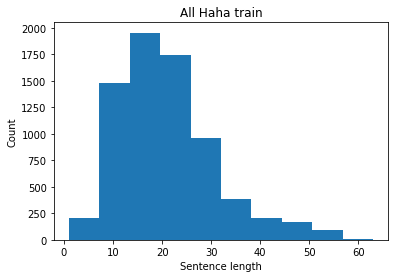

Haha train sent lengths min: 1 mean: 20.886805555555554 median: 19.0 max: 63


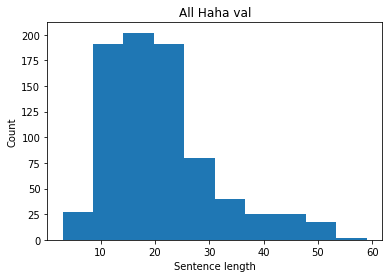

Haha val sent lengths min: 3 mean: 20.9125 median: 19.0 max: 59


array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ])

In [29]:
haha_train_sent_lengths = []

for t in haha_train_texts:
    haha_train_sent_lengths.append(len(t.split()))
haha_train_sent_lengths = np.array(haha_train_sent_lengths)

n, train_bins, _ = plt.hist(haha_train_sent_lengths, bins=10)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("All Haha train")
plt.show()
print("Haha train sent lengths min:", np.min(haha_train_sent_lengths), "mean:", np.mean(haha_train_sent_lengths), "median:", np.median(haha_train_sent_lengths), "max:", np.max(haha_train_sent_lengths))

haha_val_sent_lengths = []

for t in haha_val_texts:
    haha_val_sent_lengths.append(len(t.split()))
haha_val_sent_lengths = np.array(haha_val_sent_lengths)

n, val_bins, _ = plt.hist(haha_val_sent_lengths, bins=10)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("All Haha val")
plt.show()
print("Haha val sent lengths min:", np.min(haha_val_sent_lengths), "mean:", np.mean(haha_val_sent_lengths), "median:", np.median(haha_val_sent_lengths), "max:", np.max(haha_val_sent_lengths))

train_bins

Check for any difference in performance depending on text length. There does not seem to be a significant difference between models with and without intermediate finetuning.

---------------------------------------
model: distilroberta-base


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


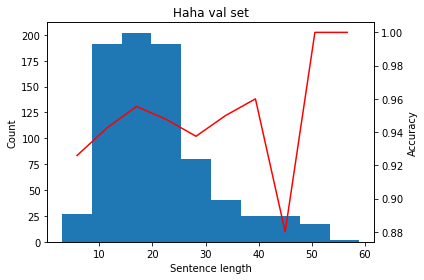

---------------------------------------
model: distilbert-base-uncased


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


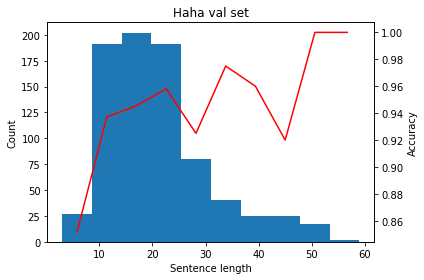

---------------------------------------
model: roberta-large


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


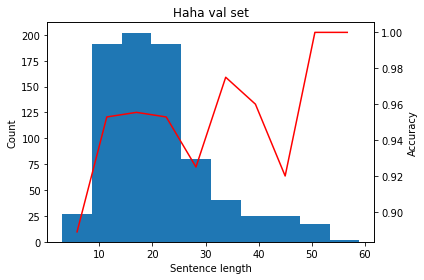

---------------------------------------
model: bert-large-uncased-whole-word-masking


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


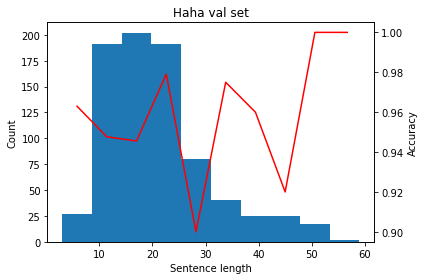

---------------------------------------
model: albert-base-v2


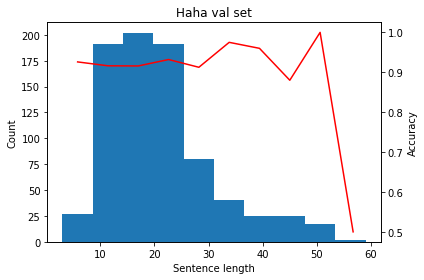

---------------------------------------
model: roberta-base


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


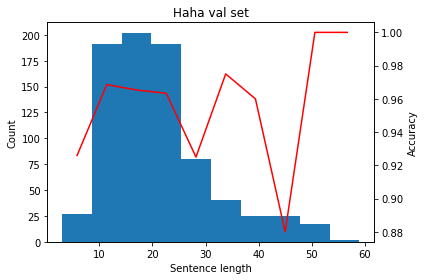

---------------------------------------
model: bert-base-uncased


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


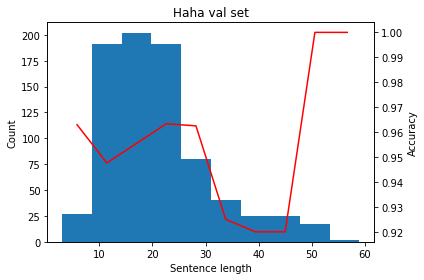

---------------------------------------
ensemble by average
humor f1: 0.9473684210526316 acc: 0.9629629629629629
humor rating rmse: 0.2675193767032353
humor controversy f1: 0.4 acc: 0.4
offense rating rmse: 0.43714806312569926
humor f1: 0.9626865671641791 acc: 0.9476439790575916
humor rating rmse: 0.46587387314220624
humor controversy f1: 0.5826771653543307 acc: 0.5923076923076923
offense rating rmse: 0.5504646563680508
humor f1: 0.9652509652509652 acc: 0.9554455445544554
humor rating rmse: 0.4853529879699658
humor controversy f1: 0.5413533834586465 acc: 0.5271317829457365
offense rating rmse: 0.6710398585299026
humor f1: 0.9696969696969697 acc: 0.9633507853403142
humor rating rmse: 0.44668731271888407
humor controversy f1: 0.6016260162601625 acc: 0.5739130434782609
offense rating rmse: 0.4541829283877847
humor f1: 0.9375 acc: 0.925
humor rating rmse: 0.5153418985739292
humor controversy f1: 0.6086956521739131 acc: 0.64
offense rating rmse: 0.368752446939389
humor f1: 0.983050847457627

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


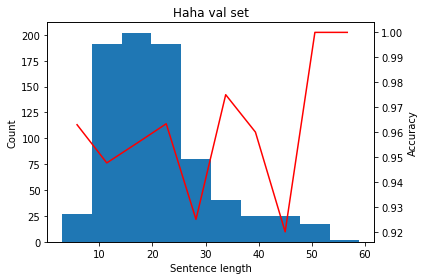

In [47]:
all_humor_preds = []
all_humor_rating_preds = []
all_controversy_preds = []
all_off_preds = []

humor_sent_lengths = val_sent_lengths[haha_val_humor_ratings != -1]

for m in models:
    print("---------------------------------------")
    print("model:", m)
    base_path = "/content/drive/My Drive/Hahackathon/"
    humor_pred = np.load(base_path + m + "_predictions_humor.npy")
    all_humor_preds.append(humor_pred)
    humor_ratings_pred = np.load(base_path + m + "_predictions_humor_rating.npy")
    all_humor_rating_preds.append(humor_ratings_pred)
    controversy_pred = np.load(base_path + m + "_predictions_humor_controversy.npy")
    all_controversy_preds.append(controversy_pred)
    off_pred = np.load(base_path + m + "_predictions_off.npy")
    all_off_preds.append(off_pred)

    bin_positions = []
    humor_f1_per_bin = []
    humor_acc_per_bin = []

    humor_bin_positions = []

    for b in range(1, len(val_bins)):
        bin_min = val_bins[b-1]
        bin_max = val_bins[b]
        if b == len(val_bins) - 1:
            bin_max += 1
        bin_indices = (val_sent_lengths >= bin_min) & (val_sent_lengths < bin_max)
        humor_bin_indices = (humor_sent_lengths >= bin_min) & (humor_sent_lengths < bin_max)

        bin_position = (bin_max + bin_min) / 2

        if np.sum(bin_indices) > 0:
            bin_positions.append(bin_position)
            # humor f1 and acc
            f1 = f1_score(haha_val_humor_labels[bin_indices], humor_pred[bin_indices])#, labels=[0, 1], average='macro')
            acc = accuracy_score(haha_val_humor_labels[bin_indices], humor_pred[bin_indices])
            # print("humor f1:", f1, "acc:", acc)
            humor_f1_per_bin.append(f1)
            humor_acc_per_bin.append(acc)

            if np.sum(humor_bin_indices) > 0:
                # humor rating rmse
                rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1][humor_bin_indices], humor_ratings_pred[humor_bin_indices], squared=False)
                # print("humor rating rmse:", rmse)

                # humor controversy f1 and acc
                f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1][humor_bin_indices], controversy_pred[humor_bin_indices])#, labels=[0, 1], average='macro')
                acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1][humor_bin_indices], controversy_pred[humor_bin_indices])
                # print("humor controversy f1:", f1, "acc:", acc)

            # humor rating rmse
            rmse = mean_squared_error(haha_val_off_ratings[bin_indices], off_pred[bin_indices], squared=False)
            # print("offense rating rmse:", rmse)

    # print(bin_positions)
    fig, ax1 = plt.subplots()
    ax1.hist(haha_val_sent_lengths, bins=10)
    ax1.set_xlabel("Sentence length")
    ax1.set_ylabel("Count")

    ax2 = ax1.twinx()
    # ax2.plot(bin_positions, humor_f1_per_bin, label="F1")
    ax2.plot(bin_positions, humor_acc_per_bin, "r", label="ACC")
    # ax2.set_ylabel("Performance")
    ax2.set_ylabel("Accuracy")

    plt.title("Haha val set")
    fig.tight_layout()
    # plt.legend()
    plt.show()


print("---------------------------------------")
print("ensemble by average")

ensemble_humor_pred = np.round(np.mean(all_humor_preds, axis=0))
ensemble_humor_ratings_pred = np.mean(all_humor_rating_preds, axis=0)
ensemble_controversy_pred = np.round(np.mean(all_controversy_preds, axis=0))
ensemble_off_pred = np.mean(all_off_preds, axis=0)

bin_positions = []
humor_f1_per_bin = []
humor_acc_per_bin = []

humor_bin_positions = []

# print(ensemble_humor_pred)
for b in range(1, len(val_bins)):
    bin_min = val_bins[b-1]
    bin_max = val_bins[b]
    if b == len(val_bins) - 1:
        bin_max += 1
    bin_indices = (val_sent_lengths >= bin_min) & (val_sent_lengths < bin_max)
    humor_bin_indices = (humor_sent_lengths >= bin_min) & (humor_sent_lengths < bin_max)

    bin_position = (bin_max + bin_min) / 2

    if np.sum(bin_indices) > 0:
        bin_positions.append(bin_position)
        # humor f1 and acc
        f1 = f1_score(haha_val_humor_labels[bin_indices], ensemble_humor_pred[bin_indices])#, labels=[0, 1], average='macro')
        acc = accuracy_score(haha_val_humor_labels[bin_indices], ensemble_humor_pred[bin_indices])
        print("humor f1:", f1, "acc:", acc)
        humor_f1_per_bin.append(f1)
        humor_acc_per_bin.append(acc)

        if np.sum(humor_bin_indices) > 0:
            # humor rating rmse
            rmse = mean_squared_error(haha_val_humor_ratings[haha_val_humor_ratings != -1][humor_bin_indices], ensemble_humor_ratings_pred[humor_bin_indices], squared=False)
            print("humor rating rmse:", rmse)

            # humor controversy f1 and acc
            f1 = f1_score(haha_val_humor_controversy[haha_val_humor_controversy != -1][humor_bin_indices], ensemble_controversy_pred[humor_bin_indices])#, labels=[0, 1], average='macro')
            acc = accuracy_score(haha_val_humor_controversy[haha_val_humor_controversy != -1][humor_bin_indices], ensemble_controversy_pred[humor_bin_indices])
            print("humor controversy f1:", f1, "acc:", acc)

        # humor rating rmse
        rmse = mean_squared_error(haha_val_off_ratings[bin_indices], ensemble_off_pred[bin_indices], squared=False)
        print("offense rating rmse:", rmse)

# print(bin_positions)
fig, ax1 = plt.subplots()
ax1.hist(haha_val_sent_lengths, bins=10)
ax1.set_xlabel("Sentence length")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
# ax2.plot(bin_positions, humor_f1_per_bin, label="F1")
ax2.plot(bin_positions, humor_acc_per_bin, "r", label="ACC")
# ax2.set_ylabel("Performance")
ax2.set_ylabel("Accuracy")

plt.title("Haha val set")
fig.tight_layout()
# plt.legend()
plt.show()

humor only-- train size: 128000 val size: 32000
encoding texts with pretrained tokenizer...


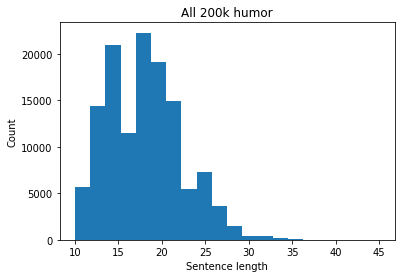

h200k sent lengths min: 10 mean: 17.9122578125 median: 17.0 max: 45
humor train partition 0 size: 25600
humor train partition 1 size: 25600
humor train partition 2 size: 25600
humor train partition 3 size: 25600
humor train partition 4 size: 25600
humor val size: 32000


In [ ]:

# train_file = "/content/drive/My Drive/OLID/olid-training-v1.0.tsv"
# test_tweets = "/content/drive/My Drive/OLID/testset-levela.tsv"
# test_labels = "/content/drive/My Drive/OLID/labels-levela.csv"

# hatebase_file = "/content/drive/My Drive/Hatebase/labeled_data.csv"

humor200k_train_file = "/content/drive/My Drive/humor_200k/train.csv"
humor200k_dev_file = "/content/drive/My Drive/humor_200k/dev.csv"
humor200k_test_file = "/content/drive/My Drive/humor_200k/test.csv"

# print("reading csvs...", flush=True)

# train_df = pd.read_csv(train_file, sep="\t", encoding="utf-8")
# test_tweets_df = pd.read_csv(test_tweets, sep="\t", encoding="utf-8")
# test_labels_df = pd.read_csv(test_labels, names=["index", "label"], encoding="utf-8")

# hatebase_df = pd.read_csv(hatebase_file)

# print("splitting into train/val...", flush=True)

# train_texts, train_off_labels = list(train_df["tweet"]), train_df["subtask_a"]
# test_texts, test_off_labels = list(test_tweets_df["tweet"]), test_labels_df["label"]

# print("olid training size:", len(train_texts), flush=True)
# print("hatebase training size:", len(hatebase_df["tweet"]), flush=True)

# # print(train_labels, flush=True)
# # print(test_labels, flush=True)

# train_off_labels = list(train_off_labels.replace("OFF", 1).replace("NOT", 0).astype('int32'))
# test_off_labels = list(test_off_labels.replace("OFF", 1).replace("NOT", 0).astype('int32'))

# # print(train_labels, flush=True)
# # print(test_labels, flush=True)

# NUM_LABELS = 2
# train_texts = preprocess_texts(train_texts)
# test_texts = preprocess_texts(test_texts)

# train_texts, val_texts, train_off_labels, val_off_labels = train_test_split(train_texts, train_off_labels, test_size=.2)

# hatebase_labels = list(hatebase_df["class"].replace(0, 1).replace(2, 0))

# train_texts += preprocess_texts(list(hatebase_df["tweet"]))
# train_off_labels += hatebase_labels

# train_humor_labels = list(np.ones(len(train_off_labels)) * -1)
# val_humor_labels = list(np.ones(len(val_off_labels)) * -1)
# test_humor_labels = list(np.ones(len(test_off_labels)) * -1)

# print("offensive only-- train size:", len(train_texts), "val size:", len(val_texts), "test size:", len(test_texts))

humor200k_train_df = pd.read_csv(humor200k_train_file, encoding="utf-8")
humor200k_dev_df = pd.read_csv(humor200k_dev_file, encoding="utf-8")

h200k_train_texts, h200k_train_humor_labels = list(humor200k_train_df["text"]), np.array(humor200k_train_df['humor'].astype(int))
h200k_val_texts, h200k_val_humor_labels = list(humor200k_dev_df["text"]), np.array(humor200k_dev_df['humor'].astype(int))

h200k_train_texts, h200k_val_texts, h200k_train_humor_labels, h200k_val_humor_labels = train_test_split(h200k_train_texts, h200k_train_humor_labels, test_size=.2)

h200k_train_humor_ratings = np.ones(len(h200k_train_humor_labels)) * -1
h200k_train_humor_controversy = np.ones(len(h200k_train_humor_labels)) * -1
h200k_train_off_ratings = np.ones(len(h200k_train_humor_labels)) * -1
h200k_val_humor_ratings = np.ones(len(h200k_val_humor_labels)) * -1
h200k_val_humor_controversy = np.ones(len(h200k_val_humor_labels)) * -1
h200k_val_off_ratings = np.ones(len(h200k_val_humor_labels)) * -1

print("humor only-- train size:", len(h200k_train_texts), "val size:", len(h200k_val_texts))


print("encoding texts with pretrained tokenizer...", flush=True)

# h200k_train_encodings = tokenizer(h200k_train_texts, truncation=True, padding=True)
# print(np.array(h200k_train_encodings['input_ids']) != 0)
h200k_train_sent_lengths = np.sum(np.array(h200k_train_encodings['input_ids']) != tokenizer.pad_token_id, axis=1)
plt.hist(h200k_train_sent_lengths, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("All 200k humor")
plt.show()
print("h200k sent lengths min:", np.min(h200k_train_sent_lengths), "mean:", np.mean(h200k_train_sent_lengths), "median:", np.median(h200k_train_sent_lengths), "max:", np.max(h200k_train_sent_lengths))
# h200k_val_encodings = tokenizer(h200k_val_texts, truncation=True, padding=True)

# humor_train_dataset = HahaDataset(h200k_train_encodings, h200k_train_humor_labels, h200k_train_humor_ratings, h200k_train_humor_controversy, h200k_train_off_ratings)
# humor_val_dataset = HahaDataset(h200k_val_encodings, h200k_val_humor_labels, h200k_val_humor_ratings, h200k_val_humor_controversy, h200k_val_off_ratings)

# indices = list(range(len(h200k_train_humor_labels)))
# np.random.shuffle(indices)
# num_partitions = 5
# partition_size = int(len(h200k_train_humor_labels) / num_partitions)
# h200k_train_partitions = {}
# for i in range(num_partitions):
#     subset_indices = np.array(indices[i * partition_size: (i+1) * partition_size])
#     subset_h200k_train_encodings = tokenizer(list(np.array(h200k_train_texts)[subset_indices]), truncation=True, padding=True)
    
#     subset_h200k_train_humor_labels = h200k_train_humor_labels[subset_indices]
#     subset_h200k_train_humor_ratings = h200k_train_humor_ratings[subset_indices]
#     subset_h200k_train_humor_controversy = h200k_train_humor_controversy[subset_indices]
#     subset_h200k_train_off_ratings = h200k_train_off_ratings[subset_indices]

#     h200k_train_partitions[i] = HahaDataset(subset_h200k_train_encodings, subset_h200k_train_humor_labels, subset_h200k_train_humor_ratings, subset_h200k_train_humor_controversy, subset_h200k_train_off_ratings)

#     print("humor train partition", i, "size:", len(h200k_train_partitions[i]))    
# print("humor val size:", len(humor_val_dataset))

# train_texts += h200k_train_texts
# val_texts += h200k_val_texts
# test_texts += h200k_test_texts
# train_off_labels += h200k_train_off_labels
# val_off_labels += h200k_val_off_labels
# test_off_labels += h200k_test_off_labels
# train_humor_labels += h200k_train_humor_labels
# val_humor_labels += h200k_val_humor_labels
# test_humor_labels += h200k_test_humor_labels

# print("combined-- train size:", len(train_texts), "val size:", len(val_texts), "test size:", len(test_texts))

# num_humor = np.sum(np.array(train_humor_labels) != -1)
# num_off = np.sum(np.array(train_off_labels) != -1)

# num_largest = np.max([num_humor, num_off])

# if num_humor > 0:
#     weight_humor = num_largest / num_humor
# else:
#     weight_humor = 0.0
# if num_off > 0:
#     weight_off = num_largest / num_off
# else:
#     weight_off = 0.0

# print("number of train examples that have humor labels:", num_humor)
# print("number of train examples that have offensive labels:", num_off)
# print("weight for humor class:", weight_humor)
# print("weight for offensive class:", weight_off)

# print("encoding texts with pretrained tokenizer...", flush=True)

# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# print("creating datasets...", flush=True)

# train_dataset = HahaDataset(train_encodings, train_off_labels, train_humor_labels)
# val_dataset = HahaDataset(val_encodings, val_off_labels, val_humor_labels)
# test_dataset = HahaDataset(test_encodings, test_off_labels, test_humor_labels)